# Calibrating the Liquid Drop Model

The purpose of this challenge is for you to calibrate the Liquid Drop Model https://en.wikipedia.org/wiki/Semi-empirical_mass_formula and compare the results of a "black box" calibration vs a principled Bayesian one.

Your task is to:

- Import the data from the AME 2016 table (included in the github). We are only using nuclei above A=16 to avoid light nuclei where the LDM fails particularly. Perform a curve fit using the built in functions from python (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) and take note of the reported uncertainties in the parameters. 
- Make a plot of the residuals and estimate the model error on its best fit. 
- Make a model calibration using the Bayesian formalism we defined and a Metropolis sampler. For the error, use your estimation from the previous point (the model error in this case is much smaller than the actual experimental uncertainties). 
- Plot the corner plot posterior as well as the model values on the Binding Energy per nucleon for the Calcium chain up to 60Ca including the available experimental data.
- What would be the results if you have used in the calibration the Binding Energy per nucleon instead of the total Binding Energy?
- Bonus: Find the experimental error in the masses and repeat the calibration using only experimental errors. This should give a good demonstration on the dangers of not taking into account model errors. 


In [1]:
import numpy as np

In [2]:
data = np.loadtxt('Masses2016.txt', skiprows=1)

def LDM(x, *params):
    #x = (n,z)
    #params= parameters (volume, surface, asymmetry, Coulomb)
    
    n=x[0]
    z=x[1]
    
    return params[0]*(n+z) - params[1]*(n+z)**(2/3) - params[2]*((n-z)**2/(n+z)) - params[3]*((z**2)/((n+z)**(1/3)))

In [3]:
# look at the data (n, z, binding energy)
print(data)
print(len(data))

[[   9.          8.         77.756552]
 [  10.          8.         85.67097 ]
 [  11.          8.         91.231445]
 ...
 [ 158.        108.       1261.127134]
 [ 159.        110.       1262.774486]
 [ 160.        110.       1270.604   ]]
2416


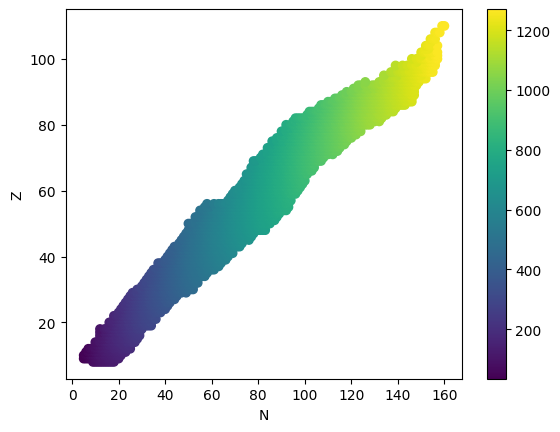

In [4]:
# heat map for the (n,z)
import matplotlib.pyplot as plt
plt.xlabel('N')
plt.ylabel('Z')
plt.scatter(data[:,0], data[:,1], c=data[:,2])
plt.colorbar()

In [12]:
# fit curve using scipy.optimize.curve_fit
from scipy.optimize import curve_fit
xdata = np.array([data[:,0], data[:,1]])  # (n,z)
ydata = data[:,2]
ans, cov = curve_fit(LDM,xdata,ydata, p0=np.array([1,1,1,1]))
print(ans)
print(cov)


[10.4618677  14.24325763  5.40685517  0.49088531]
[[1.81140977e-03 5.57812446e-03 4.07639863e-03 1.24611243e-04]
 [5.57812446e-03 1.74525926e-02 1.23581620e-02 3.76099757e-04]
 [4.07639863e-03 1.23581620e-02 1.12402635e-02 2.74655197e-04]
 [1.24611243e-04 3.76099757e-04 2.74655197e-04 8.86830024e-06]]


In [13]:
!pip install emcee

Model error:  276.3584829725343


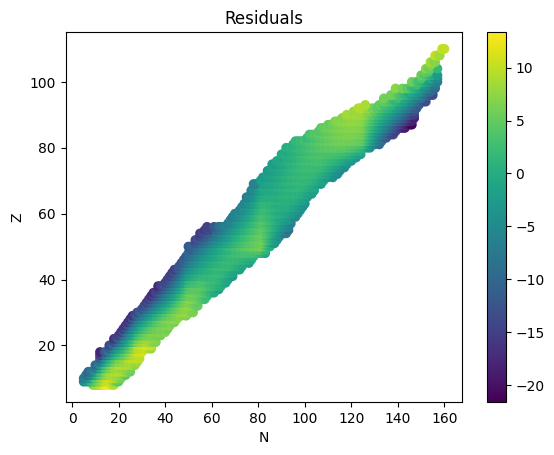

In [16]:
# make residuals plot
func_eval = LDM(xdata, *ans)
residuals = ydata - func_eval

model_error = np.sqrt(np.sum(residuals**2.0))
print('Model error: ', model_error)

plt.scatter(data[:,0], data[:,1], c=residuals)
plt.xlabel('N')
plt.ylabel('Z')
plt.title('Residuals')
plt.colorbar()


In [17]:
std_dev = np.sqrt(np.diag(cov))
print('Parameter error: ', std_dev)

# solve the model with error from parameters


Parameter error:  [0.04256066 0.13210826 0.10602011 0.00297797]


In [ ]:
# calibrate the parameters using emcee
def likelihood(params, x, sig):

    # the likelihood for the LDM
    # chi-squared will suffice

    pre = (np.sqrt(2.0 * np.pi * sig**2.0))**(-1.0)
    chisq = np.exp((LDM(x, *params) - ydata)**2.0/(2.0 * sig)**2.0)

    chi = pre * chisq

    return np.log(chi)